In [64]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import random

In [65]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Number of images in positive folder: 422
Number of images in negative folder: 147


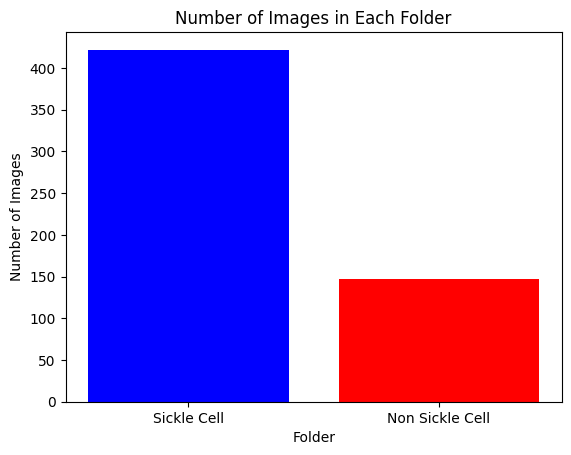

In [66]:
# Function to count the number of images in a folder
def count_images(folder):
    count = 0
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more extensions if needed
            count += 1
    return count

# Count images in each folder
positive_count = count_images('/content/drive/MyDrive/sc ds/positive')
negative_count = count_images('/content/drive/MyDrive/sc ds/neg')

# Print the counts
print("Number of images in positive folder:", positive_count)
print("Number of images in negative folder:", negative_count)

# Plot the counts
labels = ['Sickle Cell', 'Non Sickle Cell']
counts = [positive_count, negative_count]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Folder')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')
plt.show()

In [67]:
# Path to your dataset folders
sickle_cell_dir = '/content/drive/MyDrive/sc ds'
non_sickle_cell_dir = '/content/drive/MyDrive/sc ds'

In [68]:
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = datasets.ImageFolder(root=image_folder, transform=transform)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [69]:
# Create datasets
sickle_cell_dataset = torchvision.datasets.ImageFolder(root=sickle_cell_dir, transform=transform)
non_sickle_cell_dataset = torchvision.datasets.ImageFolder(root=non_sickle_cell_dir, transform=transform)

In [70]:
# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([sickle_cell_dataset, non_sickle_cell_dataset])

In [71]:
# Split dataset into training, validation, and testing sets
train_size = int(0.8 * len(combined_dataset))
val_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size, test_size])

In [72]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [73]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [74]:
# Define ResNet18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes (positive and negative)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [75]:
# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Sample images from sickle cell class:
Sample images from non-sickle cell class:


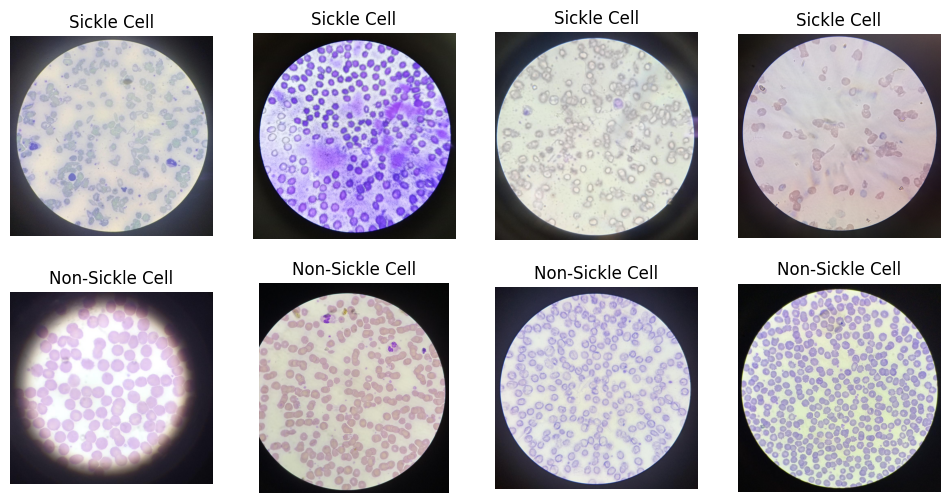

In [76]:
# Path to the folders
positive_dir = "/content/drive/MyDrive/sc ds/positive"  # Folder containing sickle cell images
negative_dir = "/content/drive/MyDrive/sc ds/neg"       # Folder containing non-sickle cell images

# Get a list of file names from each folder
positive_files = os.listdir(positive_dir)
negative_files = os.listdir(negative_dir)

# Select random images from each class
num_samples = 4
positive_samples = random.sample(positive_files, num_samples)
negative_samples = random.sample(negative_files, num_samples)

# Display sample images from positive class (sickle cell)
print("Sample images from sickle cell class:")
plt.figure(figsize=(12, 6))
for i, file in enumerate(positive_samples):
    img = mpimg.imread(os.path.join(positive_dir, file))
    plt.subplot(2, num_samples, i+1)
    plt.imshow(img)
    plt.title("Sickle Cell")
    plt.axis("off")

# Display sample images from negative class (non-sickle cell)
print("Sample images from non-sickle cell class:")
for i, file in enumerate(negative_samples):
    img = mpimg.imread(os.path.join(negative_dir, file))
    plt.subplot(2, num_samples, num_samples+i+1)
    plt.imshow(img)
    plt.title("Non-Sickle Cell")
    plt.axis("off")

plt.show()

In [77]:
# Test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / total
    return accuracy

test_accuracy = test_model(model, test_loader)


In [78]:
# Training and testing loop
def train_model(model, criterion, optimizer, num_epochs=100):
    train_loss_history = []
    val_loss_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_dataset)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataset)
        val_loss_history.append(val_loss)

        # Test phase
        test_accuracy = test_model(model, test_loader)
        test_accuracy_history.append(test_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Test Accuracy: {test_accuracy:.4f}')

    return train_loss_history, val_loss_history, test_accuracy_history

In [79]:
# Train the model for 100 epochs
train_loss_history, val_loss_history, test_accuracy_history = train_model(model, criterion, optimizer, num_epochs=100)

Epoch [1/100], Train Loss: 0.5989, Val Loss: 0.5455, Test Accuracy: 0.8174
Epoch [2/100], Train Loss: 0.5815, Val Loss: 0.5218, Test Accuracy: 0.8174
Epoch [3/100], Train Loss: 0.5743, Val Loss: 0.5160, Test Accuracy: 0.8174
Epoch [4/100], Train Loss: 0.5593, Val Loss: 0.5123, Test Accuracy: 0.8174
Epoch [5/100], Train Loss: 0.5297, Val Loss: 0.4931, Test Accuracy: 0.8174
Epoch [6/100], Train Loss: 0.4985, Val Loss: 0.4239, Test Accuracy: 0.8174
Epoch [7/100], Train Loss: 0.4715, Val Loss: 0.4447, Test Accuracy: 0.8261
Epoch [8/100], Train Loss: 0.4143, Val Loss: 0.3708, Test Accuracy: 0.7739
Epoch [9/100], Train Loss: 0.4103, Val Loss: 0.3365, Test Accuracy: 0.8087
Epoch [10/100], Train Loss: 0.3553, Val Loss: 0.4749, Test Accuracy: 0.7043
Epoch [11/100], Train Loss: 0.3593, Val Loss: 0.2965, Test Accuracy: 0.8261
Epoch [12/100], Train Loss: 0.3122, Val Loss: 0.2947, Test Accuracy: 0.8870
Epoch [13/100], Train Loss: 0.3198, Val Loss: 0.2781, Test Accuracy: 0.8783
Epoch [14/100], Train

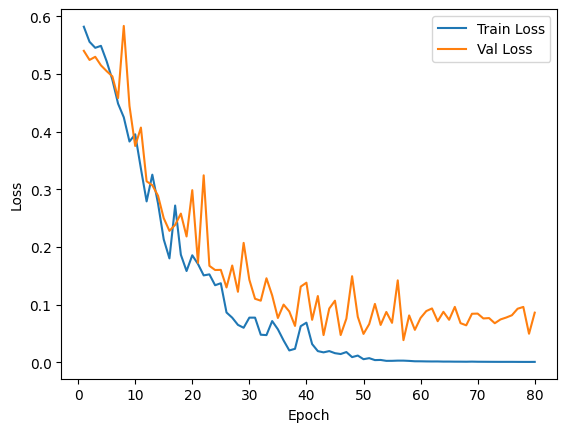

In [103]:
# Plot training and validation losses
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [82]:
# Define function for k-fold cross-validation
def k_fold_cross_validation(model, criterion, optimizer, k, X, y):
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        test_sampler = torch.utils.data.SubsetRandomSampler(test_index)

        train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=32, sampler=train_sampler)
        test_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=32, sampler=test_sampler)

        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = correct / total
            accuracies.append(accuracy)

    return np.mean(accuracies)


In [86]:
# Set hyperparameters
num_epochs = 10
learning_rate = 0.001
k = 5

In [90]:
# Prepare data for k-fold cross-validation
X = np.arange(len(sickle_cell_dataset) + len(non_sickle_cell_dataset))
y = np.array(sickle_cell_dataset.targets + non_sickle_cell_dataset.targets)

In [87]:
# Perform k-fold cross-validation
average_accuracy = k_fold_cross_validation(model, criterion, optimizer, k, X, y)
print(f'Average Accuracy after {k}-fold cross-validation: {average_accuracy:.4f}')

Average Accuracy after 5-fold cross-validation: 1.0000


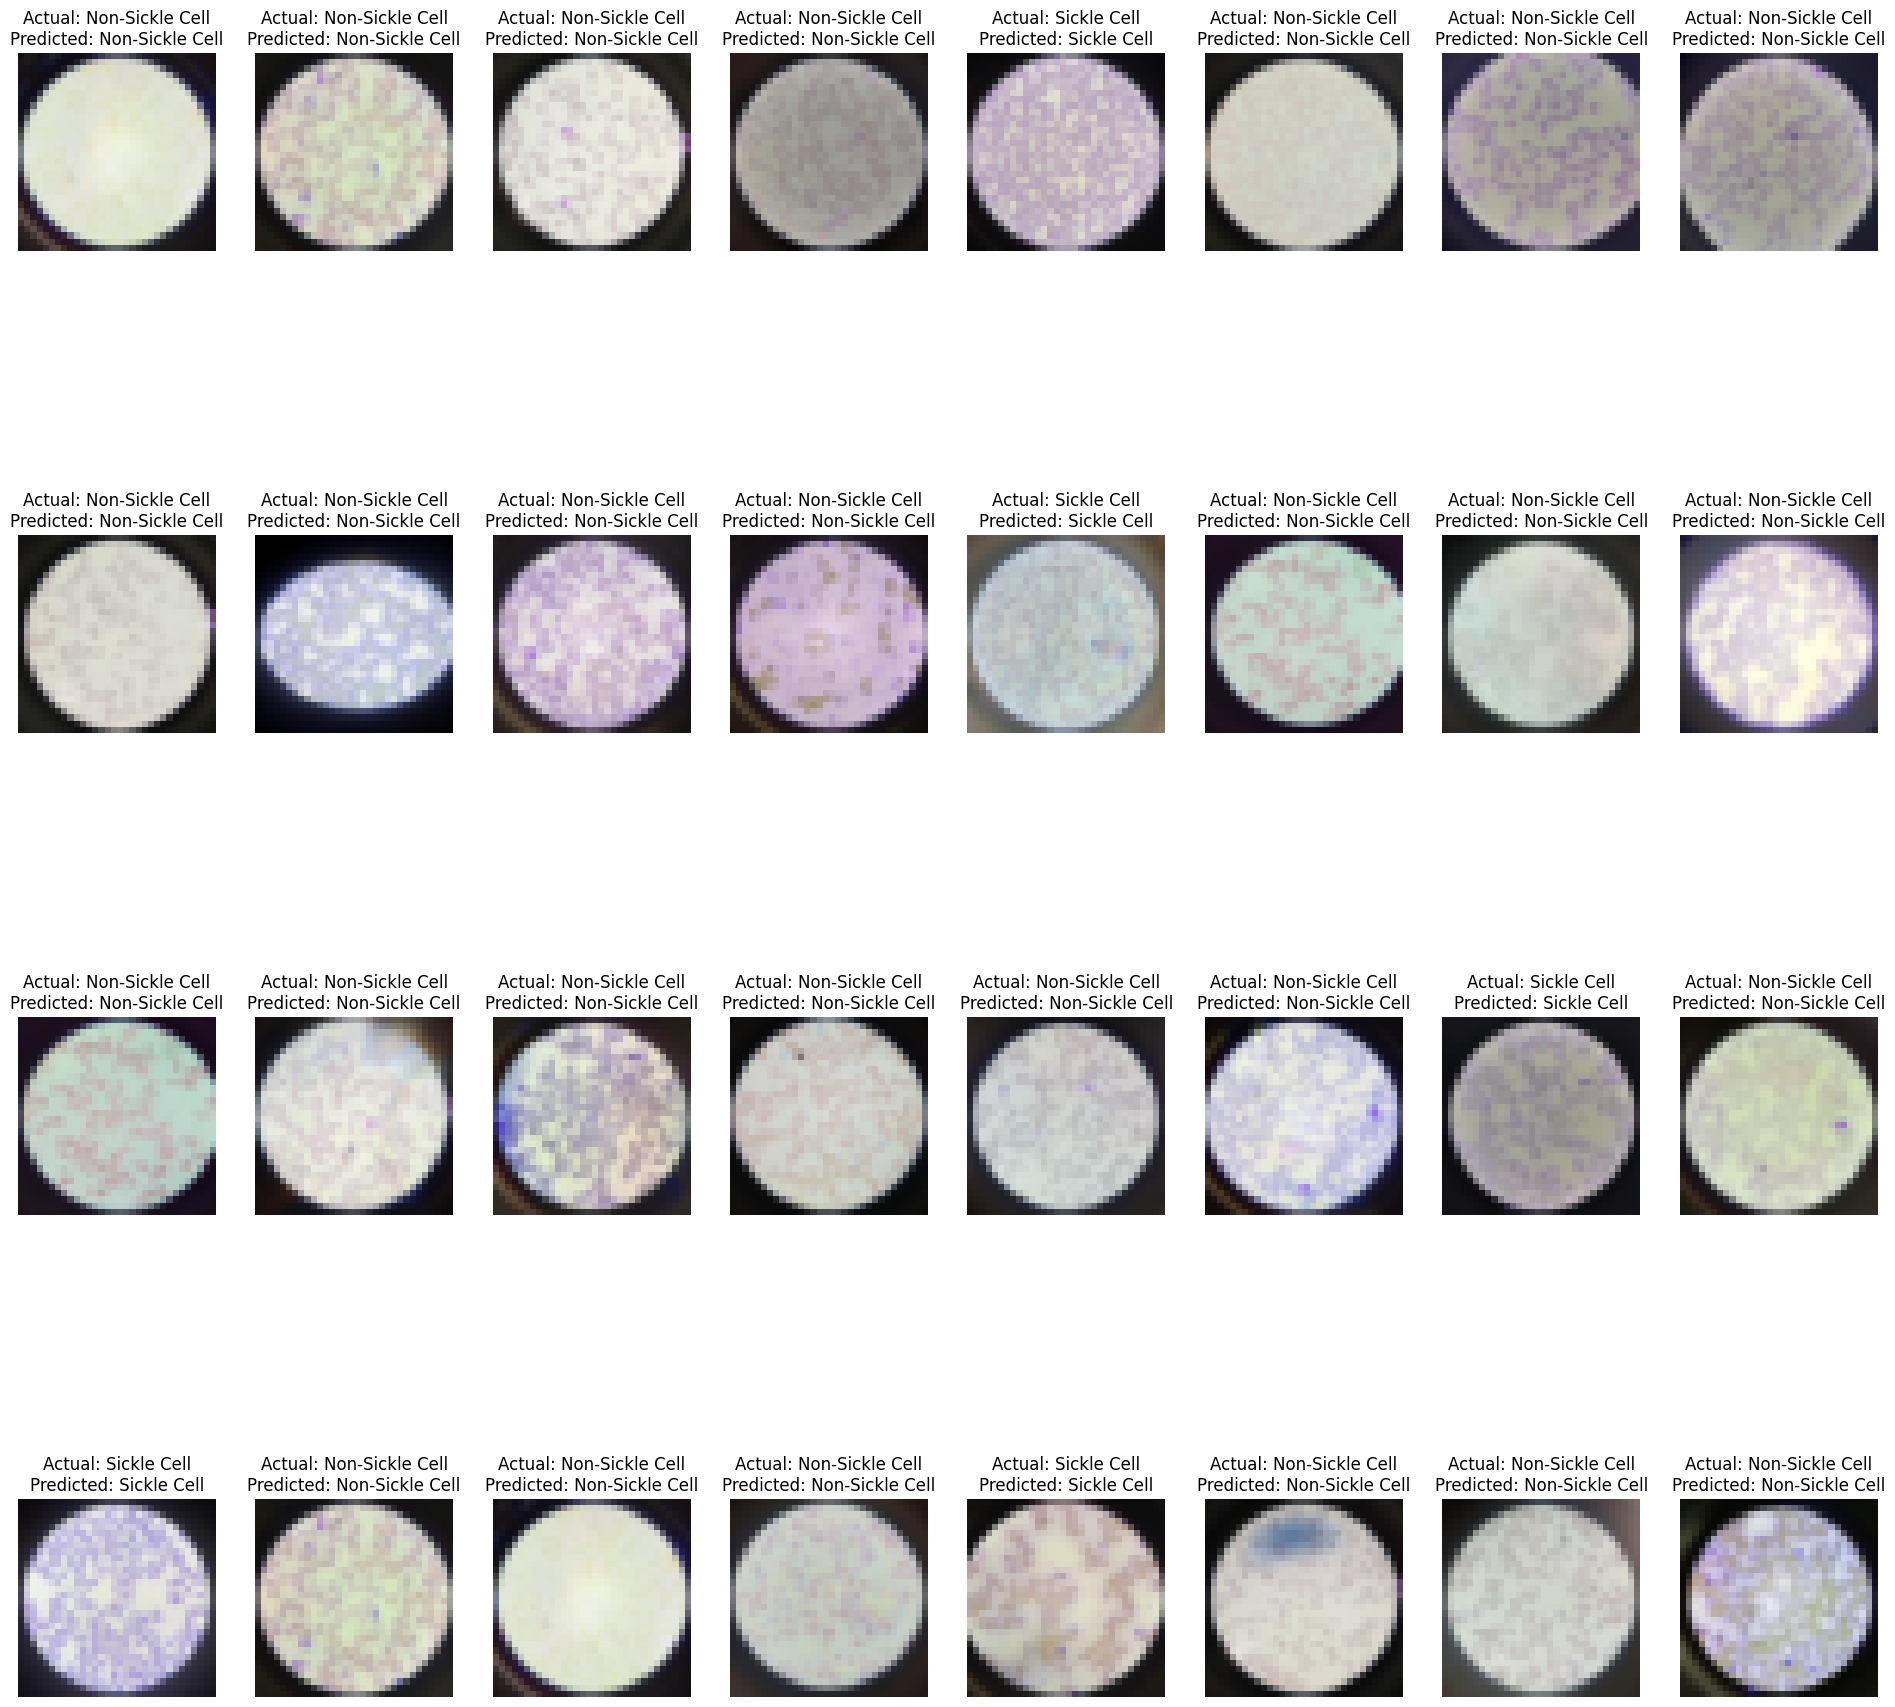

In [89]:
# Set model to evaluation mode
model.eval()

# Get a batch of test data
images, labels = next(iter(test_loader))

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert labels and predictions to numpy arrays
labels_array = labels.numpy()
predicted_array = predicted.numpy()

# Define class labels
class_labels = ['Sickle Cell', 'Non-Sickle Cell']

# Display sample images with actual and predicted labels
plt.figure(figsize=(24, 24))
for i in range(images.size(0)):
    image = images[i] / 2 + 0.5  # Unnormalize
    np_image = image.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    plt.subplot(4, 8, i + 1)
    plt.imshow(np_image)
    plt.title(f'Actual: {class_labels[labels_array[i]]}\nPredicted: {class_labels[predicted_array[i]]}')
    plt.axis('off')

plt.show()

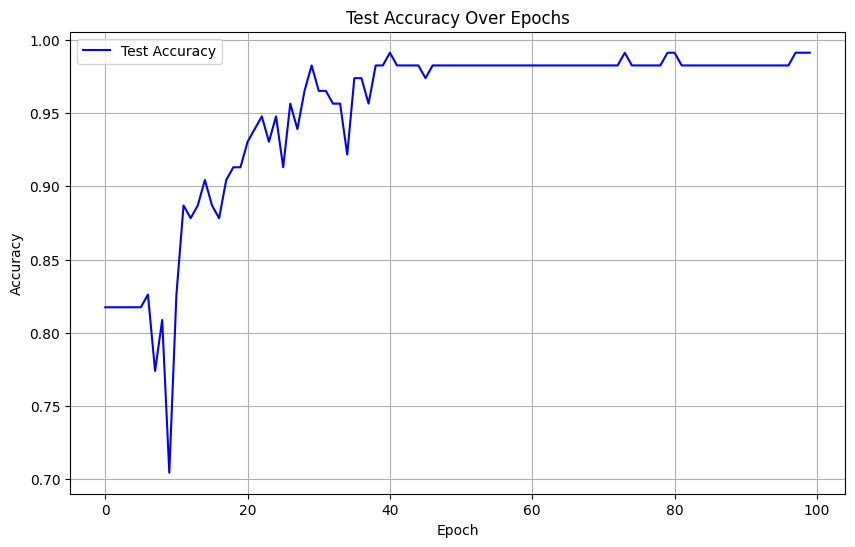

In [88]:
# Plot the test accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(test_accuracy_history, label='Test Accuracy', color='blue')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()